<a href="https://colab.research.google.com/github/rahiakela/deep_learning_for_vision_systems/blob/master/6-transfer-learning/3_fine_tuningpretrained_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer learning approaches

There are three major transfer learning approaches as follows:

1. Pretrained network as a classifier
2. Pretrained network as feature extractor
3. Fine tuning

Each approach can be effective and save significant time in developing and training a deep convolutional neural network model. It may not be clear as to which usage of the pre-trained model may yield the best results on your new computer vision task, therefore some experimentation may be required.

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import mobilenet, imagenet_utils
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files

import numpy as np
import itertools
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

## Fine tuning the pretrained network

we are going to explore scenario #3 that was discussed earlier in this chapter. Where the target dataset is small and it very different from the source dataset. The goal of
this project is to build a **Sign Language Classifier** that classifies between 10 classes. The classes are the digits from 0 to 9.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/sign-language-dataset.png?raw=1' width='800'/>

**Dataset details**:

Our dataset contains the following:

- Number of classes = 10 (digits 0, 1, 2, 3, 4, 5, 6, 7, 8, and 9)
- Total number of images
- Image size = 100x100
- Color space = RGB
- 1712 images in the training set
- 300 images in the validation set
- 50 images in the test set


It is very noticeable how small our dataset is. If you try to train your network from scratch on
this very small dataset, you will not achieve any good results. On the other hand, we were
able to achieve an accuracy higher than 98% using transfer learning even though the source
and target domains were so different.

For ease of comparison with the previous project, we are going to use VGG16 network that
was trained on ImageNet dataset as well.

The process that we are going to use to fine tune a pretrained network is as follows:

1. Preprocess the data to make it ready for the neural network
2. Load in pretrained weights from the VGG16 network trained on a large dataset (ImageNet)
3. Freeze part of the feature extractor part
4. Add the new classifier layers
5. Compile the network and run the training process to optimize the model for the smaller dataset
6. Evaluate the model

Now let’s go through these steps one-by-one and implement this project.

## 1- Preprocess the data to make it ready for the neural network

Keras has this ImageDataGenerator class which allows us to perform image augmentation on the fly in a very easy way. You can read about that in Keras’s official [documentation](https://keras.io/api/preprocessing/image/). In this example, we are going to use the ImageDataGenerator class to generate our image tensors but we are not going to implement image augmentation for simplicity.

The ImageDataGenerator class has a method called flow_from_directory() that is used to read the images from folders containing images. This method expects your data directory to be structured as follows:

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/directory-structure.png?raw=1' width='800'/>

I have the data structured for you in the Github repo to be ready for you to use
flow_from_directory() method.

In [2]:
# download dataset
! git clone https://github.com/rahiakela/machine-learning-datasets -b sign_language_dataset

Cloning into 'machine-learning-datasets'...
remote: Enumerating objects: 4119, done.
remote: Counting objects: 100% (4119/4119), done.
remote: Compressing objects: 100% (3465/3465), done.
remote: Total 4119 (delta 655), reused 4117 (delta 653), pack-reused 0
Receiving objects: 100% (4119/4119), 51.90 MiB | 12.72 MiB/s, done.
Resolving deltas: 100% (655/655), done.


In [3]:
!ls

machine-learning-datasets  sample_data


In [4]:
import zipfile

# Unzipping files
zip_file = "machine-learning-datasets/sign_language_dataset.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(".")

Now, let’s load the data into train_path, valid_path, and
test_path variables then generate the train, valid, and test batches:

In [5]:
train_path  = 'sign_language_dataset/train'
valid_path  = 'sign_language_dataset/valid'
test_path  = 'sign_language_dataset/test'

# ImageDataGenerator generates batches of tensor image data with real-time data augmentation.
# The data will be looped over (in batches). in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(train_path, target_size=(224, 224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(valid_path, target_size=(224, 224), batch_size=30)
test_batches  = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(test_path, target_size=(224, 224), batch_size=50, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


## 2- Download VGGNet and create network

We are going to download the VGG16 network from Keras and download it’s weights after being pretrained on ImageNet dataset. Remember that we want to remove the classifier part from this network so we will set the parameter include_top=False.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/transfer_network.png?raw=1' width='800'/>

Note that we used the parameter pooling=’avg’ here. This is basically means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor. We use this as an alternative to the Flatten layer before adding the FC layers.


In [6]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling='avg')
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

## 3- Freeze part of the feature extractor part

Here we want to freeze only a part of the feature extraction part and fine tune the rest on our
new training data. Remember that in fine tuning we want to freeze part of the network and
tune the rest. How we decide the level of fine tuning is usually determined by trial and error.

VGG16 has 13 convolutional layers, you can freeze them all or freeze few of them depends on
how similar your data is to the source data. In the sign language case, the new domain is very
different from our domain, so we will start with fine tuning only the last 5 layers then if we
don’t get satisfying results we can fine tune more. It turns out that after we trained the new
model, we got 98% accuracy so this is a good level of fine tuning. But in other cases, if you
find that your network didn’t converge, try to fine tune more layers.

In [7]:
# iterate through its layers and lock them except for the last 5 layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [8]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 4- Add the new classifier layers

Now let's add a few layers on top of the base model. In this example, we will add one FC layer with 64 hidden units and a softmax with 2 hidden units. We will also add batch norm and dropout layers to avoid overfitting.

In [9]:
# use “get_layer” method to save the last layer of the network
# save the output of the last layer to be the input of the next layer
last_layer = base_model.get_layer('global_average_pooling2d')
last_output = last_layer.output

# add our new softmax layer with 3 hidden units
x = Dense(10, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 5- Compile the network and run the training process to optimize the model for the smaller dataset

In [10]:
checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

In [11]:
new_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = new_model.fit(train_batches, steps_per_epoch=18, validation_data=valid_batches, 
                        validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])

Epoch 1/20
18/18 [==============================] - 47s 765ms/step - loss: 2.8163 - accuracy: 0.2667 - val_loss: 1.7561 - val_accuracy: 0.3778
Epoch 2/20
18/18 [==============================] - 3s 193ms/step - loss: 1.5864 - accuracy: 0.3833 - val_loss: 1.1443 - val_accuracy: 0.6444
Epoch 3/20
18/18 [==============================] - 3s 192ms/step - loss: 0.8986 - accuracy: 0.6667 - val_loss: 0.5692 - val_accuracy: 0.8111
Epoch 4/20
18/18 [==============================] - 5s 268ms/step - loss: 0.7285 - accuracy: 0.7674 - val_loss: 0.7601 - val_accuracy: 0.7222
Epoch 5/20
18/18 [==============================] - 3s 188ms/step - loss: 0.2953 - accuracy: 0.9111 - val_loss: 0.4198 - val_accuracy: 0.8444
Epoch 6/20
18/18 [==============================] - 3s 187ms/step - loss: 0.1998 - accuracy: 0.9389 - val_loss: 0.2309 - val_accuracy: 0.9000
Epoch 7/20
18/18 [==============================] - 3s 188ms/step - loss: 0.1217 - accuracy: 0.9611 - val_loss: 0.1363 - val_accuracy: 0.9444
Epoch

Notice the training time of each epoch from the verbose above. It took the model approximately the model was trained very quickly using a regular CPU computing power. Each
epoch took approximately 25 to 29 seconds which means that it took the model less than 10 minutes to train for 20 epochs.

## 6- Evaluate the model.

Now, let’s use Keras’s evaluate() method to calculate the model accuracy.

In [12]:
def load_dataset(path):
  data = load_files(path)
  paths = np.array(data['filenames'])
  targets = to_categorical(np.array(data['target']))

  return paths, targets

In [13]:
test_files, test_targets = load_dataset("sign_language_dataset/test")

In [14]:
def path_to_tensor(img_path): 
  # loads RGB image as PIL.Image.Image type
  image = load_img(img_path, target_size=(224, 224))

  # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
  x = img_to_array(image)

  # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor 
  return np.expand_dims(x, axis=0)

In [15]:
def paths_to_tensor(img_paths):
  list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]

  return np.vstack(list_of_tensors)

In [16]:
test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 50/50 [00:00<00:00, 519.66it/s]


Loading the trained model

In [17]:
new_model.load_weights('signlanguage.model.hdf5')

In [18]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

2/2 [==============================] - 17s 6s/step - loss: 0.0422 - accuracy: 0.9800

Testing loss: 0.0422
Testing accuracy: 0.9800


A deeper level of evaluating your model is to create the confusion matrix. It is a table that is often used to describe the performance of a classification model to give us a deeper understanding of how the model performed on the test dataset.

Now, let’s build the confusion matrix for our model.

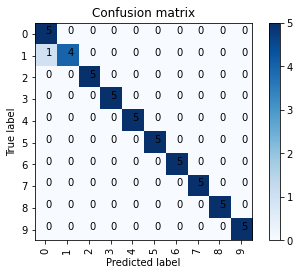

In [19]:
cm_labels = ['0','1','2','3','4','5','6','7','8','9']

cm = confusion_matrix(np.argmax(test_targets, axis=1), np.argmax(new_model.predict(test_tensors), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

To read this confusion matrix, look at the number in the Predicted Label axis and check if it
was correctly classified in the True Label axis. For example, look at number 0 in predicted
label axis, you will see that all 5 images are classified as 0 and zero number of images were
mistakenly classified as any other number. Similarly, go through the rest of the numbers in
the predicted label axis. You will notice that the model as successfully made the correct
predictions for all the test images except for the image with true label = 8. Where the model
has mistakenly classified an image of number 8 and thought it was number = 7.

In [20]:
# evaluate and print test accuracy
score = new_model.evaluate(test_tensors, test_targets)
print('\n', 'Test accuracy:', score[1])

2/2 [==============================] - 0s 213ms/step - loss: 0.0422 - accuracy: 0.9800

 Test accuracy: 0.9800000190734863
